# SVM Facial Recognition
Overview:
* Raw data contains 13233 images, each 62 x 47 pixels
* Filter dataset to return people with at least 45 images to identify them by (1483 images in data subset)
* Data represent gray scales (i.e. values have been converted from RBG to gray scale and stored as numeric values)

Sources:
* [SVM Guide for Image Recognition](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)
* [SKLearn Dataset Docs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)

### Load Data
Extract data (details above) from SKLearn library and peek at a few of the elements of the dataset (features, targets etc.).

In [12]:
# load data
from sklearn.datasets import fetch_lfw_people

# extract data
faces = fetch_lfw_people(min_faces_per_person=45)

# peek at data
faces.data.shape

(1483, 2914)

In [13]:
faces.data[0]

array([ 63.333332,  71.      ,  77.333336, ...,  56.      ,  94.333336,
       111.666664], dtype=float32)

In [14]:
faces.images[0].shape

(62, 47)

In [15]:
faces.target.shape

(1483,)

In [16]:
faces.target

array([ 1,  2,  4, ...,  3, 10,  6], dtype=int64)

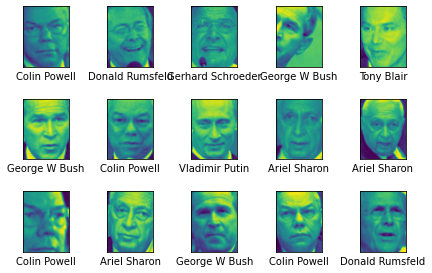

In [62]:
# load libraries
import matplotlib.pyplot as plt

# define 3x5 grid
fig, ax = plt.subplots(3, 5)
fig.tight_layout() # space grid a little better

# iterate through plots
for i, axi in enumerate(ax.flat):
    # show images in raw format
    axi.imshow(faces.images[i])
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

### Pipeline Brief
Steps:
* Split data into train and test sets
* Feature normalization/standardization
* Feature selection/dimensionality reduction (PCA)
* Build, fit and score model
* Hyperparameter tuning (using GridSearchCV)
* Score final model (classification report, confusion matrix)

Further Reading:
* [Extracting Features from Images](https://www.analyticsvidhya.com/blog/2019/08/3-techniques-extract-features-from-image-data-machine-learning-python/)

### Train, Test & Split
It is important that we carry out this stage before making any changes to our data, this is to avoid leaking solutions, inferences and general knowledge about our data into our validation set (i.e. we must keep our test set entirely separate to avoid artificially improving our model).

In [43]:
# load libraries
from sklearn.model_selection import train_test_split

# specify X and y data from inputs
X = faces.data
y = faces.target

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# check split
print("X_train: ", X_train.shape, "X_test: ", X_test.shape)
print("y_train: ", y_train.shape, "y_test: ", y_test.shape)

X_train:  (1186, 2914) X_test:  (297, 2914)
y_train:  (1186,) y_test:  (297,)


Here you can see we have have 1186 samples in our training set and 297 in our test set, this should be plenty to continue with.

### Feature Normalization/Standardization
Before committing to this step, let's investigate our features to see if they need normalizing. The clue will be whether the variance and mean of each feature is similar or drastically different across the board.

In [44]:
# load libraries
import pandas as pd
import numpy as np

# convert features into dataframe
features_df = pd.DataFrame(data=faces.data,
                           index=None,
                           columns=range(0,faces.data.shape[1]))

# show range of means and standard deviations
means = features_df.describe().loc['mean']
stds = features_df.describe().loc['std']

print("Mean Range: ", np.round(means.min(), 2), np.round(means.max(), 2))
print("Std Range: ", np.round(stds.min(), 2), np.round(stds.max(),2 ))

# check range and mean of features
features_df.describe()

Mean Range:  79.55 179.55
Std Range:  25.16 79.34


,0,1,2,3,4,5,6,7,8,9,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
count,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,...,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000
mean,93.924301,96.676735,102.036369,110.020721,119.343147,128.038712,135.518509,141.435745,146.193954,150.347275,...,110.396790,117.004425,123.880829,128.915054,130.534225,128.751816,125.217201,120.329460,113.597763,107.428177
std,46.997093,45.549625,44.215958,43.381737,42.757355,42.054462,40.210434,38.500240,37.601986,36.758133,...,59.328976,63.552273,67.938286,71.469299,73.522179,75.504349,77.325371,78.118187,78.344551,79.339798
min,0.000000,0.000000,0.000000,0.666667,1.000000,1.666667,2.333333,2.333333,5.000000,10.666667,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.333332,64.333336,71.000000,80.333336,92.666664,102.000000,111.000000,117.833332,123.333336,128.666672,...,65.666664,69.166668,71.500000,68.500000,68.166668,61.000000,51.666668,45.833334,39.666668,35.000000
50%,89.333336,93.000000,101.000000,109.333336,118.666664,128.666672,137.000000,142.666672,147.333328,152.000000,...,104.000000,110.333336,117.333336,126.666664,127.333336,125.333336,123.333336,116.666664,102.333336,88.666664
75%,124.000000,126.000000,131.333328,138.666672,148.166664,156.333328,162.333328,167.000000,171.333328,174.500000,...,146.166664,159.166664,175.666672,188.666672,196.833336,197.666664,197.833336,192.500000,187.500000,176.833336
max,243.333328,244.333328,246.333328,247.000000,247.000000,249.333328,252.000000,251.666672,249.333328,253.000000,...,252.333328,253.666672,254.666672,254.666672,255.000000,255.000000,255.000000,255.000000,254.666672,255.000000


We can see here that the range of means is quite significant as is the standard deviation (i.e. variance), therefore we will perform normalization to adjust all features means to 0 and standard deviation to 1 (or close to it).

In [49]:
# load libraries
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit on training set only (avoid leakage)
scaler.fit(X_train)

# apply transformation to train and test sets
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# convert scaled features into dataframe
features_df = pd.DataFrame(data=X_train_sc,
                           index=None,
                           columns=range(0,X_train_sc.shape[1]))

# show range of means and standard deviations
means = features_df.describe().loc['mean']
stds = features_df.describe().loc['std']

print("Mean Range: ", np.round(means.min(), 2), np.round(means.max(), 2))
print("Std Range: ", np.round(stds.min(), 2), np.round(stds.max(),2 ))

# peek at data
features_df.describe()

Mean Range:  -0.0 0.0
Std Range:  1.0 1.0


,0,1,2,3,4,5,6,7,8,9,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
count,1.186000e+03,1.186000e+03,1.186000e+03,1.186000e+03,1.186000e+03,1.186000e+03,1.186000e+03,1.186000e+03,1.186000e+03,1.186000e+03,...,1.186000e+03,1.186000e+03,1.186000e+03,1.186000e+03,1.186000e+03,1.186000e+03,1.186000e+03,1.186000e+03,1.186000e+03,1.186000e+03
mean,5.075944e-09,-3.417467e-09,-1.083538e-07,1.758990e-08,-4.121063e-09,3.417467e-09,-4.221577e-09,1.753965e-08,-1.181036e-08,-1.030266e-08,...,6.633906e-09,3.216440e-09,5.025687e-10,-4.724146e-09,2.814385e-09,6.589932e-09,-3.115926e-09,-2.336944e-09,-9.297520e-09,3.794394e-09
std,1.000422e+00,1.000422e+00,1.000421e+00,1.000422e+00,1.000422e+00,1.000422e+00,1.000421e+00,1.000422e+00,1.000422e+00,1.000422e+00,...,1.000422e+00,1.000422e+00,1.000421e+00,1.000422e+00,1.000422e+00,1.000422e+00,1.000422e+00,1.000421e+00,1.000421e+00,1.000422e+00
min,-2.004989e+00,-2.132884e+00,-2.323031e+00,-2.545036e+00,-2.814546e+00,-3.053733e+00,-3.358485e+00,-3.627269e+00,-3.753424e+00,-3.797412e+00,...,-1.817698e+00,-1.797500e+00,-1.779924e+00,-1.758970e+00,-1.749429e+00,-1.683186e+00,-1.602624e+00,-1.525533e+00,-1.434668e+00,-1.339344e+00
25%,-7.302260e-01,-7.208908e-01,-7.227192e-01,-6.797157e-01,-6.205103e-01,-6.236519e-01,-6.205360e-01,-6.217625e-01,-6.265069e-01,-6.169776e-01,...,-7.382761e-01,-7.523751e-01,-7.818618e-01,-8.522643e-01,-8.605411e-01,-9.126031e-01,-9.359943e-01,-9.599382e-01,-9.327207e-01,-9.137288e-01
50%,-9.899816e-02,-7.312062e-02,-1.586780e-02,-1.159887e-02,-1.280982e-02,1.913845e-03,2.836626e-02,3.141991e-02,3.785256e-02,4.174591e-02,...,-1.230617e-01,-1.070107e-01,-8.957827e-02,-3.611298e-02,-4.855432e-02,-4.294544e-02,-3.066797e-02,-5.349463e-02,-1.691653e-01,-2.695267e-01
75%,6.306940e-01,6.528913e-01,6.702492e-01,6.449320e-01,6.817050e-01,6.916397e-01,6.688960e-01,6.607317e-01,6.756374e-01,6.642509e-01,...,6.151955e-01,6.729135e-01,7.568179e-01,8.264766e-01,9.002714e-01,8.982663e-01,9.391710e-01,9.189882e-01,9.091707e-01,8.717512e-01
max,3.129230e+00,3.202121e+00,3.248843e+00,3.162922e+00,3.009908e+00,2.905179e+00,2.912842e+00,2.865494e+00,2.668715e+00,2.667585e+00,...,2.399317e+00,2.163522e+00,1.943240e+00,1.774977e+00,1.711127e+00,1.685361e+00,1.687517e+00,1.733829e+00,1.815228e+00,1.876412e+00


You can see that the mean of our data is 0 and that the standard deviation is 1 for all features, our data is now scaled and can be processed further.

### Feature Selection/Dimensionality Reduction (PCA)
**PCA (Principle Component Analysis)** is a method of reducing high dimensional data (i.e. our raw pixel data of 2914 features) to a lower dimension where far fewer principle components (i.e. clusters on a lower dimensional axis) can be more neatly separated. For example, you can apply PCA to reduce our raw 2914 features to 3 principle components.

Here, the components are determined by grouping the lower dimensional clusters based on their variance. The variance here being the numerical difference between the value of each pixel/feature value. The first principle component contains the features with the highest variance (i.e. areas of contrast or strong colour/value in our image), the second component contains the next highest variance features and so on.

Therefore, you can reduce a fairly complex, large image containing 2914 features to just 3 or 4 (or whatever you decide) clusters whilst still retaining the key inferences and distinguishing features of your images.

Reducing the number of features is important for several reasons:
* Speed of processing
* Avoiding memory issues
* ML models are more accurate and efficient when working with fewer features

**SVD (single value decomposition)** is a similar method to PCA and randomised SVD can actually be combined with SKLearn's PCA method. We can use it here by setting the svd_solver to 'randomized' and this works very well for SVM image recognition so we will implement that here.

Further Reading:
* [Excellent PCA Breakdown](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)
* [PCA Tutorial](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)
* [SKLearn Guide](https://scikit-learn.org/stable/modules/decomposition.html)
* [SKLearn PCA Docs](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
* [Detailed PCA & SVD Guide](https://towardsdatascience.com/pca-and-svd-explained-with-numpy-5d13b0d2a4d8)

Note that below we specify the number of components (clusters) we want to end up with in our transformed data. We can also specify the % of variance we'd like to be left with/capture (see commented out code) as an alternative. We can return here lataer to tweak the number of components to see how our model improves/changes with each number.

In [73]:
# load libraries
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

# instantiate PCA model
#pca = PCA(.95)
# whiten reduces potential correlation between adjacent pixels/input variables
pca = RandomizedPCA(n_components=150, svd_solver='randomized', whiten=True, random_state=42)

# create SVM model (adjusting weights/hyperplane position in the case of imbalanced classes)
svc = SVC(kernel='rbf', class_weight='balanced')

# create model containing pca and svm in pipeline
model = make_pipeline(pca, svc)

### Selecting/Tuning Parameters
We will use GridSearchCV to try different combinations of parameters with our model pipeline in order to determine the optimum combination. Here, we are mainly looking at the speed of the model by returning the fastest combination of parameters, we will tweak later on depending on model accuracy.

In an SVM algorithm, C and gamma are the two main parameters. C sets a tolerance for misclassification (higher C means fewer misclassified classes allowed) whilst gamma determines the amount which distance vectors influence the model (higher gamma means more distant vectors influence the model more strongly i.e. extends the range of the radial basis function).

In [77]:
# load libraries
from sklearn.model_selection import GridSearchCV

# define parameters to try
param_grid = {'svc__C': [0.05, 0.1, 1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}

# implement parameter combinations with model pipeline
grid = GridSearchCV(model, param_grid)

# time the results of the fitting stage
%time grid.fit(X_train_sc, y_train)

# return fastest results
print(grid.best_params_)

Wall time: 1min 54s
{'svc__C': 5, 'svc__gamma': 0.001}


### Building our Model
Now that we have selected the best performing parameters, let's run our model and have an initial look at the prediction power it has.

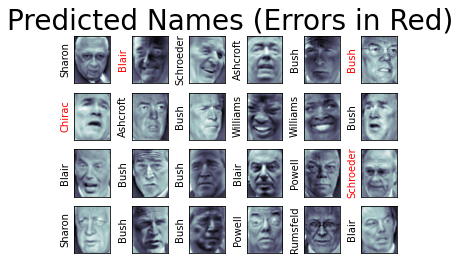

In [80]:
# select best parameters from grid search (see above)
model = grid.best_estimator_

# make predictions using model and selected parameters
y_pred = model.predict(X_test_sc)

# plot 4x6 grid of faces
fig, ax = plt.subplots(4, 6)

# plot each image
for i, axi in enumerate(ax.flat):
    # reshape data to match original image format
    axi.imshow(X_test_sc[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    
    # label each image with predicted target value
    # highlight errors in red
    axi.set_ylabel(faces.target_names[y_pred[i]].split()[-1],
                   color='black' if y_pred[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names (Errors in Red)', size=14);

### Model Accuracy
We can see here that 3 images have been mis-labelled out of a sample of 24. This is OK but potentially a higher error rate than we'd hope for.

Let's take a more in depth look at the accuracy of our model across the whole sample using a classification report and confusion matrix.

In [81]:
# load libraries
from sklearn.metrics import classification_report

# view classification report
print(classification_report(y_test, y_pred,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.77      0.71        13
     Colin Powell       0.71      0.85      0.78        41
  Donald Rumsfeld       0.70      0.80      0.74        20
    George W Bush       0.94      0.85      0.89       113
Gerhard Schroeder       0.86      0.73      0.79        33
   Jacques Chirac       0.38      0.38      0.38         8
    John Ashcroft       0.80      0.73      0.76        11
Junichiro Koizumi       0.92      1.00      0.96        11
  Serena Williams       0.70      1.00      0.82         7
       Tony Blair       0.81      0.89      0.85        28
   Vladimir Putin       0.67      0.50      0.57        12

         accuracy                           0.81       297
        macro avg       0.74      0.77      0.75       297
     weighted avg       0.82      0.81      0.81       297



Text(83.40000000000006, 0.5, 'Predicted Label')

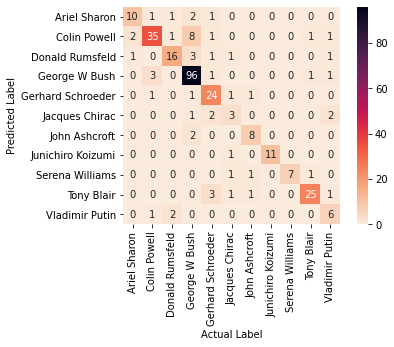

In [85]:
# load libraries
import seaborn as sns
from sklearn.metrics import confusion_matrix

# create confusion matrix (actual vs. pred)
mat = confusion_matrix(y_test, y_pred)

# plot as heatmap
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cmap=sns.cm.rocket_r,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')

We can see here that our average accuracy, precision and recall range from around 74% to 81%. Some labels are predicted very effectively (e.g. George Bush, Junichiro Koizumi), whilst others are quite poor (e.g. Jacques Chirac, Vladimir Putin).

Overall, the model accuracy is quite good but there is certainly room for improvement. Some areas which may be contributing to decreased accuracy and would be worth investigation include:
* Sample size (and number of faces per person)
* Parameter tuning (more values tested in grid search)
* Adjusting the number of components returned by PCA (more/fewer)
* Removing the normalization step and seeing if we are actually removing valuable information at this point

### Summary
SVM is an effective classifier when the data is suitable and sufficient steps have been taken, a summary of the pros and cons of this technique is as follows...

**Pros:**
* Once trained, the prediction stage is very fast/efficient
* It mainly computes the support vectors only, mostly ignoring more distant vectors, therefore it can process data where the number of features exceeds the number of samples quite significantly vs. other models
* Their ability to employ multiple kernel types makes them flexible and able to work with many different input data types/formats

**Cons:**
* The training phase can be costly, therefore it scales poorly with larger datasets compared to other, simpler models
* It requires quite careful training (particularly of the C parameter) and computing this parameter (i.e. with GridSearchCV) can be very costly as the dataset grows
* The results don't have a directly interpretable statistical meaning, computing this value can be very costly and therefore prohibit effective outputs for further work

### Further Reading
Links:
* [SVM Guide](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)
* [Hyperparameters and Model Validation](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html)
* [PCA In Depth](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)